In [2]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime as dt
import GPflow

import sys
import os
sys.path.append(os.path.abspath('../Backend'))
import wahlrecht_polling_firms


sns.set(style='white', palette='deep', color_codes=True)

%matplotlib inline

In [3]:
complete_data_dict = wahlrecht_polling_firms.get_tables()

In [4]:
parties = ['CDU/CSU', 'SPD', 'GRÜNE', 'FDP', 'LINKE', 'AfD', 'Sonstige']

In [5]:
def _prediction_to_dataframe(prediction):
    """Wrap an array with the predictions into a dataframe containing the party names."""
    return pd.DataFrame(data=[prediction], columns=parties)

_prediction_to_dataframe(range(len(parties)))

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,0,1,2,3,4,5,6


In [6]:
class Model():
    
    def fit(self, data_dict=complete_data_dict):
        """Optional fit step to call before predictions. Leave empty if the model does not support fitting."""
        return
    
    def predict(self, data_dict=complete_data_dict):
        raise NotImplementedError()
    
    def predict_all(self, data_dict=complete_data_dict):
        """Make a prediction for each time point in the data."""
        num_timesteps = max([len(df) for df in data_dict.values()])  # take the max from all dataframes
        #print('Applying model to {} time points...'.format(num_timesteps))

        # First prediction, append the other ones below.
        prediction_df = self.predict(data_dict)

        for i in range(1, num_timesteps):
            sliced_data_dict = {key: df[i:] for key, df in data_dict.items()}
            # TODO: Maybe speed up models, especially the decay models. 
            # Note: Appending the data frames takes up almost no time here, the bottleneck is the model.
            # TODO: Due to ill-formated data, the resulting dataframe contains NaNs sometimes.
            prediction_df = prediction_df.append(self.predict(sliced_data_dict), ignore_index=True)
        
        return prediction_df
    
    def score(self, data_dict=complete_data_dict, polling_firm=None):
        """Calculate a score for the model (lower is better). The score is the mean squared error between the model's predictions and the true results.
        If `polling_firm` is None (default), return a dict with the score for each polling firm. Otherwise, return only the score for that polling firm."""
        prediction_df = self.predict_all(data_dict)
    
        if polling_firm is None:
            return {polling_firm: mse(poll_df, prediction_df) for polling_firm, poll_df in data_dict.items()}
        else: 
            return mse(data_dict[polling_firm], prediction_df)

In [7]:
class GPModel(Model):
    """Average the last `n_last` polls from all polling firms."""
    
    def __init__(self, k = GPflow.kernels.Matern32(1, variance=1, lengthscales=1.2)):
        self.kernel=k
        
        
    def predict(self, data_dict=complete_data_dict):
        data = data_dict['emnid']
        Y = data[parties]
        X = pd.to_datetime(data.Datum)
        X=-(X-dt.date.today()).astype('timedelta64[D]').reshape(-1,1)
        m = GPflow.gpr.GPR(X, pd.DataFrame.as_matrix(Y), kern=self.kernel)
        m.optimize()
        
        x_pred = np.linspace(X[0,0],X[-1,0], 1000).reshape(-1,1)

        mean,var = m.predict_y(x_pred)
        prediction = mean [-1] /(mean [-1] .sum(axis=0))*100

        return _prediction_to_dataframe(prediction)
    
    def plot(m):
        # TODO : revise plotting function depending on the final data structres
        fig,ax = plt.subplots(1,figsize=(12,12))

        xx = np.linspace(-0.1, 1.1, 100)[:,None]
        mean, var = m.predict_y(x_pred)
        #plt.plot(X, Y, 'kx', mew=2)
        for y,std,c in zip(mean.T,np.sqrt(var.T),['black','red','purple','green','yellow','blue']):
            ax.fill_between(x_pred[:,0],y- 2*std,y+ 2*std,alpha=.1,color=c)
            ax.plot(x_pred,y,c=c)

        ax.scatter(X[:,0],Y['CDU/CSU'],c='black',alpha=.5,label='CDU')
        ax.scatter(X[:,0],Y.SPD,c='red',alpha=.5,label='SPD')
        ax.scatter(X[:,0],Y['Linke'],c='purple',alpha=.5,label='Linke')
        ax.scatter(X[:,0],Y.Grüne,c='green',alpha=.5,label='Grüne')
        ax.scatter(X[:,0],Y.FDP,c='yellow',alpha=.5,label='FDP')
        ax.scatter(X[:,0],Y.AfD,c='blue',alpha=.5,label='AfD')
        ax.invert_xaxis()
        ax.legend();
    
 
        
        
GPModel().predict(complete_data_dict).sum(axis=1)

/opt/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


0    100.0
dtype: float64

In [8]:
covar=(complete_data_dict['allensbach'][parties]).corr()
results = GPModel().predict(complete_data_dict)

/opt/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [9]:
results

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,41.800335,25.502056,8.962943,3.178276,9.229366,5.296601,6.030422


In [29]:
def n_days_predict (results, covar , n=5):

    props = np.array(results)
    for i in range (1,n):
        props+=np.random.multivariate_normal(np.zeros(7) , covar)
        props[props<0]=0
        props= props/(props.sum()) *100
    return props

In [30]:
def montecarlo(function,n_=10000):
    success=np.zeros((len(results)))
    outcomes = np.zeros((7,n_))
    for i in range(1, n_+1):
            
        outcomes[:,i-1]= function(results, covar)
    
    return outcomes

In [31]:
m = montecarlo( n_days_predict)

In [32]:
m.shape

(7, 10000)

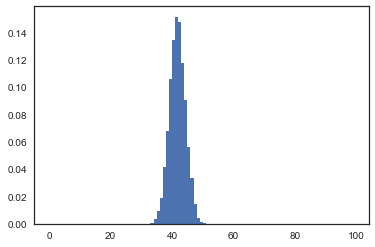

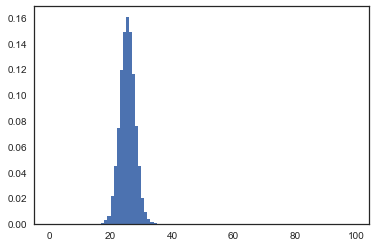

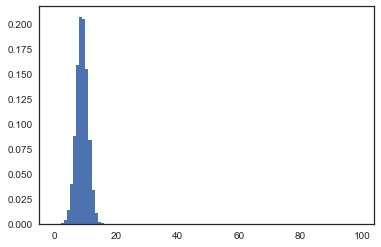

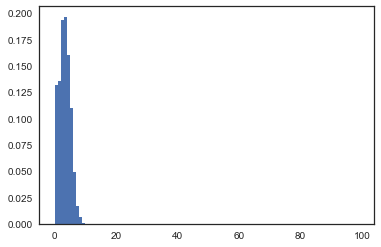

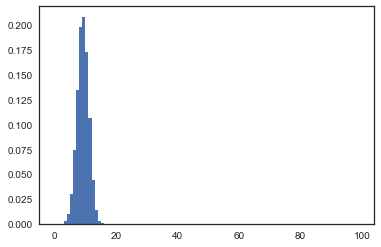

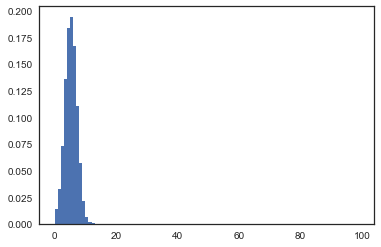

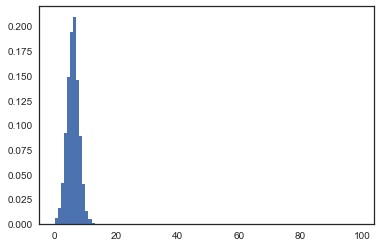

In [33]:
for i in m:
    plt.hist(i,bins=np.arange(0,100,1), normed=True)
    plt.show()